In [31]:
import torch

class Net(torch.nn.Module):

    def __init__(self, indim=1, outdim=1):
        super().__init__()
        self.actf = torch.tanh
        self.lin1 = torch.nn.Linear(indim, 30)
        self.lin2 = torch.nn.Linear(30, outdim)

    def forward(self, x):
        x = self.lin1(x)
        x = self.lin2(self.actf(x))
        return x.squeeze()

In [32]:
from torch.utils.data import Dataset, DataLoader

class MyDataset(Dataset):

    def __init__(self, in_tensor, out_tensor):
        self.inp = in_tensor
        self.out = out_tensor

    def __len__(self):
        return len(self.inp)

    def __getitem__(self, idx):
        return self.inp[idx], self.out[idx]

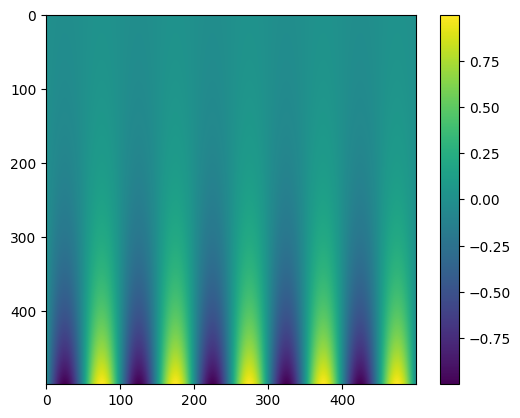

In [33]:
import numpy as np
import matplotlib.pyplot as plt

def u(x, t):
    return np.exp(-2*np.pi*np.pi*t)*np.sin(np.pi*x)

pts = 500
ts = np.linspace(0.2, 0, pts)
xs = np.linspace(-5, 5, pts)
us = u(xs, ts)

X, Y = np.meshgrid(xs, ts)
U = u(X, Y)

plt.imshow(U)
plt.colorbar()

In [34]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_in = torch.tensor([[x, t] for x, t in zip(X.flatten(), T.flatten())], dtype=torch.float32, requires_grad=True)
train_out = torch.tensor(us, dtype=torch.float32)

train_in.to(DEVICE)
train_out.to(DEVICE)

train_dataset = MyDataset(train_in, train_out)
train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)

In [35]:
from torch.optim import Adam
from torch.optim.lr_scheduler import LambdaLR
from torch.autograd import Variable

model = Net(indim=2, outdim=1).to(DEVICE)
epochs = 100
optimizer = Adam(model.parameters(), lr=0.1)
scheduler = LambdaLR(optimizer=optimizer,
					 lr_lambda=lambda epoch: 0.995**epoch,
					 last_epoch=-1)

loss_fcn = torch.nn.MSELoss()

for epoch in range(0, epochs):
    for batch_in, batch_out in train_dataloader:
        batch_in = Variable(batch_in, requires_grad=True)
        batch_in.to(DEVICE)
        batch_out.to(DEVICE)
        model.train()
        def closure():
            optimizer.zero_grad()
            loss = loss_fcn(model(batch_in), batch_out)
            loss.backward()
            return loss
        optimizer.step(closure)
    scheduler.step()
    model.eval()
    epoch_loss = loss_fcn(model(train_in), train_out)
    print(f'Epoch: {epoch+1} | Loss: {round(float(epoch_loss), 4)}')

Epoch: 1 | Loss: 0.2855
Epoch: 2 | Loss: 1.3162
Epoch: 3 | Loss: 0.2508
Epoch: 4 | Loss: 0.2062
Epoch: 5 | Loss: 0.3451
Epoch: 6 | Loss: 0.1032
Epoch: 7 | Loss: 0.1243
Epoch: 8 | Loss: 0.2095
Epoch: 9 | Loss: 0.1267
Epoch: 10 | Loss: 0.0682
Epoch: 11 | Loss: 0.1147
Epoch: 12 | Loss: 0.1152
Epoch: 13 | Loss: 0.0659
Epoch: 14 | Loss: 0.067
Epoch: 15 | Loss: 0.0876
Epoch: 16 | Loss: 0.0703
Epoch: 17 | Loss: 0.0552
Epoch: 18 | Loss: 0.0631
Epoch: 19 | Loss: 0.0675
Epoch: 20 | Loss: 0.0571
Epoch: 21 | Loss: 0.0538
Epoch: 22 | Loss: 0.0588
Epoch: 23 | Loss: 0.0578
Epoch: 24 | Loss: 0.053
Epoch: 25 | Loss: 0.0537
Epoch: 26 | Loss: 0.0556
Epoch: 27 | Loss: 0.0534
Epoch: 28 | Loss: 0.0526
Epoch: 29 | Loss: 0.0534
Epoch: 30 | Loss: 0.0531
Epoch: 31 | Loss: 0.052
Epoch: 32 | Loss: 0.0521
Epoch: 33 | Loss: 0.0523
Epoch: 34 | Loss: 0.0518
Epoch: 35 | Loss: 0.0516
Epoch: 36 | Loss: 0.0517
Epoch: 37 | Loss: 0.0515
Epoch: 38 | Loss: 0.0513
Epoch: 39 | Loss: 0.0513
Epoch: 40 | Loss: 0.0513
Epoch: 41 | 

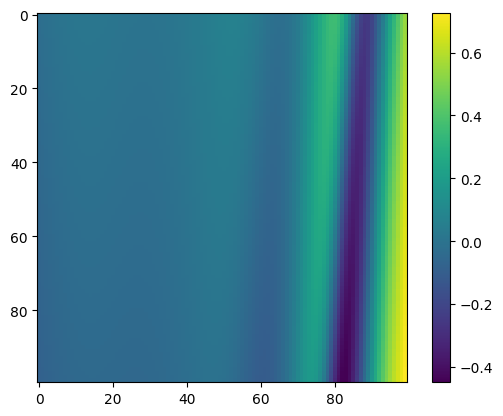

In [37]:
def u_model(xs, ts):
    pts = torch.tensor(np.array([[x, t] for x, t in zip(xs, ts)]), dtype=torch.float32)
    return model(pts)

pts = 100
ts = torch.linspace(0.2, 0, pts)
xs = torch.linspace(-5, 5, pts)
X, T = torch.meshgrid(xs, ts)
X = X.T
T = T.T

img = []
for x, t in zip(X, T):
    img.append(u_model(x, t).detach().numpy().tolist())

plt.imshow(img)
plt.colorbar()